In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
from flask import Flask, jsonify
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, text, inspect, func
from sqlalchemy.ext.declarative import declarative_base

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Lmoya\AppData\Local\Temp\ipykernel_22268\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [36]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [37]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [39]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

# Exploratory Precipitation Analysis

In [41]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date in the dataset: {most_recent_date[0]}")

The most recent date in the dataset: 2017-08-23


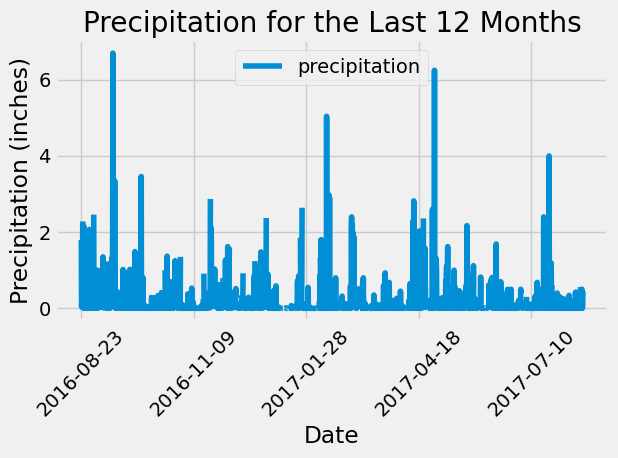

In [46]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='date', y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation for the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig("precipitation_plot.png", bbox_inches='tight')
plt.show()

In [47]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [48]:
# Design a query to calculate the total number of stations in the dataset
columns = inspector.get_columns('station')
session.query(Station.id).count()

9

In [49]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,func.count(Measurement.station)).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
most_active_stations[0][0]

'USC00519281'

In [54]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [59]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_active_stations = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]

session.query(*temp_active_stations).filter(Measurement.station == most_active_stations[0][0]).all()

[(54.0, 85.0, 71.66378066378067)]

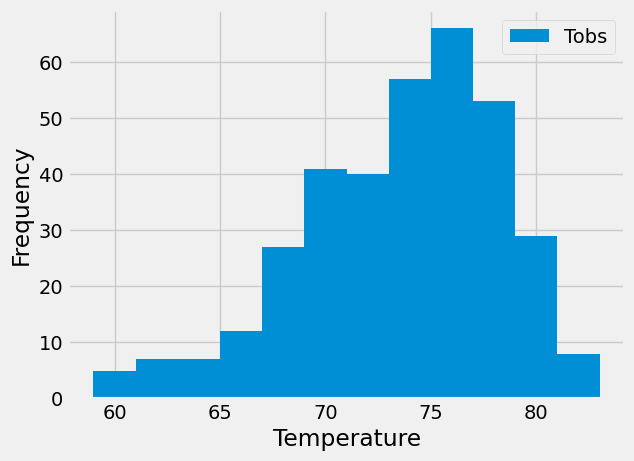

In [60]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
one_year_ago
results = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == most_active_stations[0][0]).all()
df = pd.DataFrame(results, columns=['Tobs'])
df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.savefig("Temperture_Hist.png", bbox_inches = 'tight')

# Close Session

In [61]:
# Close Session
session.close()